# Developing PDC ROP model using symbolic regression and pysr library

### Import neccassary libraries

In [1]:
import pandas as pd
import numpy as np
from pysr import pysr, best
from sklearn import preprocessing

import matplotlib.pylab as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import math

* In this study, we use the Sandia National Lab and National Oil Varco full PDC bit data.
* The data was published in ARMA conference 55TH US ROCK MECHANICS / GEOMECHANICS SYMPOSIUM 18-25 June 2021 Online.
* Paper titel is "ROP Model for PDC Bits in Geothermal Drilling".

### Read the PDC ROP data

In [33]:
data = pd.read_csv("ROP data.csv")
data.head()

,year,name,WOB,ROP data,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
0,2019,SWG,2543.8,6.2,3.75,80,28000,11,25,1,0.51,4
1,2019,SWG,3048.9,11.9,3.75,80,28000,11,25,1,0.51,4
2,2019,SWG,3538.7,19.5,3.75,80,28000,11,25,1,0.51,4
3,2019,SWG,4066.2,28.6,3.75,80,28000,11,25,1,0.51,4
4,2019,SWG,4574.9,36.6,3.75,80,28000,11,25,1,0.51,4


Check out the data frame column names.

In [4]:
data.columns

Index(['year', 'name ', 'WOB', 'ROP data', 'Db', 'RPM', 'UCS', 'NOC', 'BR',
       'SR', 'Dc', 'NOB'],
      dtype='object')

Separate the independent (X) and dependant (Y) parameters

In [5]:
keep_clmns = ['WOB', 'Db', 'RPM', 'UCS', 'NOC', 'BR', 'SR', 'Dc', 'NOB']
X = data[keep_clmns]

keep_clmns = ['ROP data',]
Y = data[keep_clmns]

Check out the X and Y top 5 values

In [6]:
X.head()

,WOB,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
0,2543.8,3.75,80,28000,11,25,1,0.51,4
1,3048.9,3.75,80,28000,11,25,1,0.51,4
2,3538.7,3.75,80,28000,11,25,1,0.51,4
3,4066.2,3.75,80,28000,11,25,1,0.51,4
4,4574.9,3.75,80,28000,11,25,1,0.51,4


In [7]:
Y.head()

,ROP data
0,6.2
1,11.9
2,19.5
3,28.6
4,36.6


Check out the mean, std, min and max values.

In [8]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
WOB,88.0,2967.525501,986.156551,1090.00,2287.50,3033.55165,3692.50,5088.248694
Db,88.0,3.750000,0.000000,3.75,3.75,3.75000,3.75,3.750000
RPM,88.0,123.636364,28.169512,80.00,100.00,120.00000,150.00,160.000000
UCS,88.0,24437.500000,7904.099220,7100.00,28000.00,28000.00000,28000.00,28000.000000
NOC,88.0,12.454545,2.094926,11.00,11.00,11.00000,13.00,16.000000
BR,88.0,19.204545,4.964608,15.00,15.00,15.00000,25.00,25.000000
SR,88.0,1.000000,0.000000,1.00,1.00,1.00000,1.00,1.000000
Dc,88.0,0.463636,0.039717,0.43,0.43,0.43000,0.51,0.510000
NOB,88.0,4.454545,0.500783,4.00,4.00,4.00000,5.00,5.000000


In [9]:
Y.describe().T

,count,mean,std,min,25%,50%,75%,max
ROP data,88.0,33.051984,27.326698,1.646927,12.2,26.125011,44.375,127.7


Turn pandas data frame into the numpy array. Numpy arrays then will be fed into the pysr algorithm.

In [10]:
X_np = np.array(X)
Y_np = np.array(Y)

In [35]:
print("The X_np shape is ", X_np.shape)
print("The Y_np shape is ", Y_np.shape)

The X_np shape is  (88, 9)
The Y_np shape is  (88, 1)


Flatten the Y numpy.

In [36]:
Y_np_flat = Y_np.flatten()
print("The Y_np_flat shape is ", Y_np_flat.shape)

The Y_np_flat shape is  (88,)


### Run the pysr library

In [15]:
%%time
# learn equation
equations = pysr(X_np,
                Y_np_flat,
                loss="LPDistLoss{2}()",
                procs=10,
                populations=10,
                niterations=20,
                binary_operators=["plus", "sub", "mult", "pow", "div"],
                unary_operators=[],
                verbosity=1, 
                variable_names=['WOB', 'Db', 'RPM', 'UCS', 'NOC', 'BR', 'SR', 'Dc', 'NOB'])

Wall time: 9min 25s                                     ]  0.0 %


In [38]:
# print(best(equation))
# best_equation = equation.iloc[equation.MSE.argmin()]

Check out the hall of fame equations

In [40]:
equations

,Complexity,MSE,score,Equation,sympy_format,lambda_format
0,1,1064.938000,0.000000,BR,BR,<function _lambdifygenerated at 0x000001E14E78...
1,3,669.070200,0.232391,(RPM / NOB),RPM/NOB,<function _lambdifygenerated at 0x000001E14E78...
2,5,597.903900,0.056229,"(RPM / pow(BR, Dc))",RPM*Abs(BR)**(-Dc),<function _lambdifygenerated at 0x000001E14E78...
3,7,161.605270,0.654137,(((RPM / Dc) * WOB) / UCS),RPM*WOB/(Dc*UCS),<function _lambdifygenerated at 0x000001E14E8C...
4,9,148.593520,0.041971,((((RPM / Dc) * WOB) / UCS) - NOB),-NOB + RPM*WOB/(Dc*UCS),<function _lambdifygenerated at 0x000001E14E8C...
5,11,95.769510,0.219635,((((RPM / Dc) * WOB) / (UCS - WOB)) - NOB),-NOB + RPM*WOB/(Dc*(UCS - WOB)),<function _lambdifygenerated at 0x000001E14E8C...
6,13,65.335846,0.191202,(((((RPM + 21.14382) / Dc) * WOB) / (UCS - WOB...,-NOC + WOB*(RPM + 21.14382)/(Dc*(UCS - WOB)),<function _lambdifygenerated at 0x000001E14E8C...
7,15,43.864544,0.199217,((((((RPM + 22.46982) / Dc) * WOB) / (UCS - WO...,-NOB - NOC + WOB*(RPM + 22.46982)/(Dc*(UCS - W...,<function _lambdifygenerated at 0x000001E14E8C...
8,17,37.821293,0.074117,(pow(((((RPM + 98.457596) / Dc) * WOB) / (UCS ...,0.31298584*Abs(NOC - WOB*(RPM + 98.457596)/(Dc...,<function _lambdifygenerated at 0x000001E14E8C...
9,19,27.875923,0.152554,(pow((((((RPM + 98.457596) / Dc) * WOB) / (UCS...,0.31298584*Abs(NOB + NOC - WOB*(RPM + 98.45759...,<function _lambdifygenerated at 0x000001E14E8C...


Define a function and edit it with the best function found by pysr library.

In [30]:
def best_equation(row):
    WOB, Db, RPM, UCS, NOC, BR, SR, Dc, NOB = row
    Y= (pow((((((RPM + 98.457596) / Dc) * WOB) / (UCS - WOB)) - NOB) - NOC, 1.1348255) * 0.31298584)
    
    return Y

Compare the results of PDC ROP model found by pysr with the data.

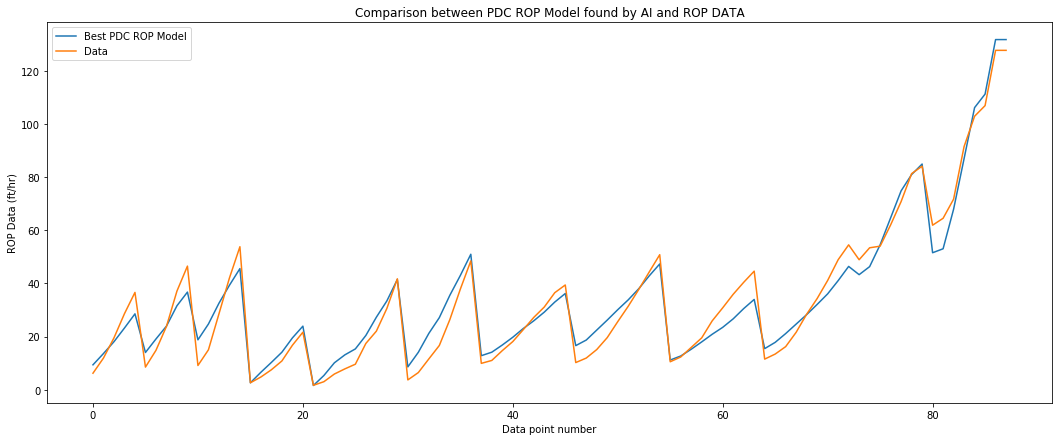

In [50]:
estimated = np.apply_along_axis(best_equation, 1, X_np)
plt.figure(figsize=(18,7))
plt.plot(estimated, label="Best PDC ROP Model")
plt.plot(Y_np, label="Data")
plt.title("Comparison between PDC ROP Model found by AI and ROP DATA")
plt.xlabel("Data point number")
plt.ylabel("ROP Data (ft/hr)")
plt.legend()
plt.show()

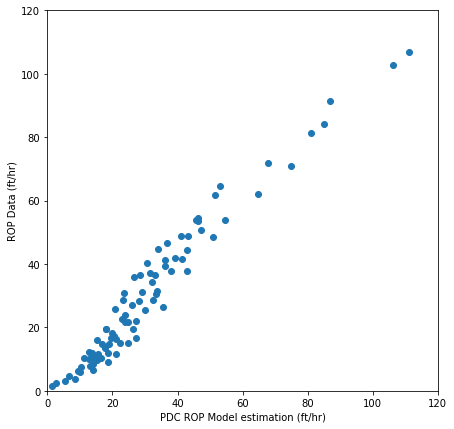

In [51]:
plt.figure(figsize=(7,7))
plt.scatter(estimated, Y_np)
plt.xlim(0,120),plt.xlabel("PDC ROP Model estimation (ft/hr)")
plt.ylim(0,120),plt.ylabel("ROP Data (ft/hr)")
plt.show()